Install the stable wrapper - ultralytics, for SAM implementation which API compatible.

In [3]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.9 MB/s eta 0:00:00


Handles the SAM2 segmentation and compares it to OpenCV implementation.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


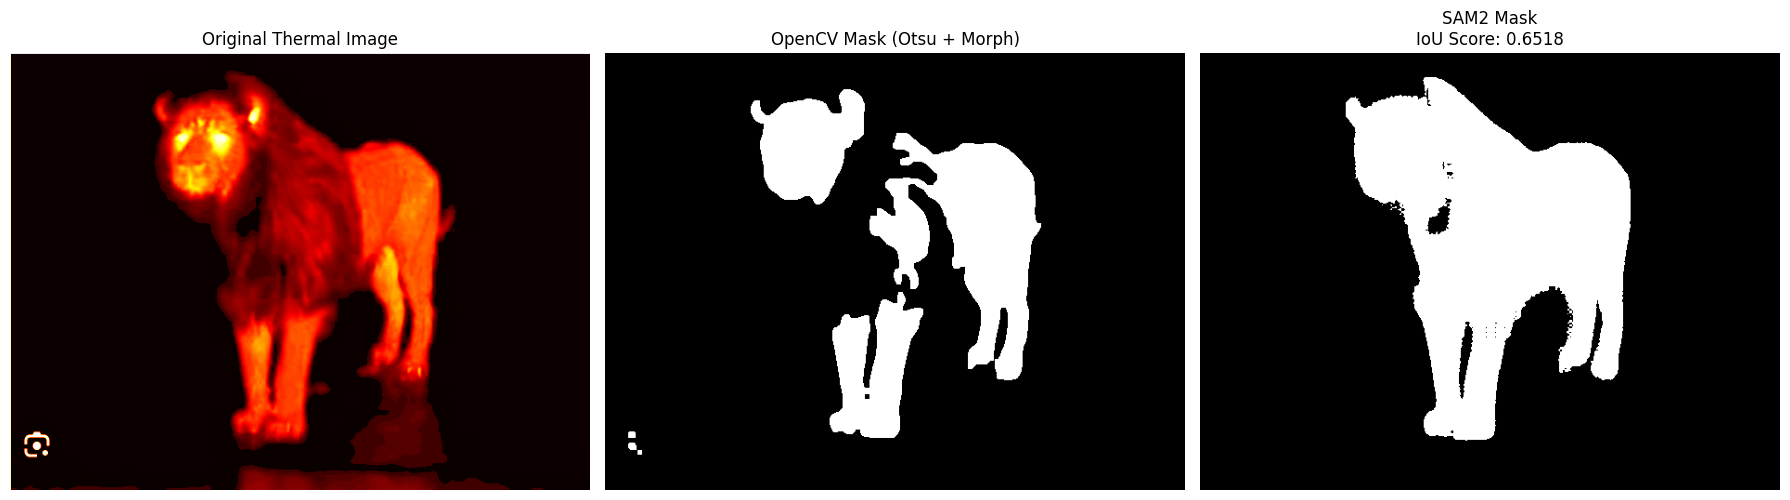

Final Comparison IoU: 0.6518


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import SAM
from google.colab.patches import cv2_imshow

# --- Part 1: OpenCV Implementation (Traditional Method) ---
def get_opencv_result(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None, None

    # Pre-processing: Bilateral filter to smooth noise
    blurred = cv2.bilateralFilter(image, 9, 75, 75)

    # Segmentation: Otsu's Thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    return image, opening

# --- Part 2: SAM2 Implementation (Deep Learning Method) ---
def get_sam2_result(image_path, x, y):
    model = SAM('sam2_b.pt') # Balanced SAM2 model
    results = model.predict(image_path, points=[[x, y]], labels=[1], verbose=False)

    if results[0].masks is not None:
        mask = results[0].masks.data[0].cpu().numpy().astype(np.uint8)
        return mask
    return None

# --- Part 3: Main Execution & Comparison ---
img_path = '/content/drive/MyDrive/CV_Week4/animal_thermal_image.png'
px, py = 400, 300 # Ensure these coordinates are on the animal in your image

original_gray, opencv_mask = get_opencv_result(img_path)
sam_mask = get_sam2_result(img_path, px, py)

if opencv_mask is not None and sam_mask is not None:
    # Resize SAM mask to match OpenCV dimensions if necessary
    if opencv_mask.shape != sam_mask.shape:
        sam_mask = cv2.resize(sam_mask, (opencv_mask.shape[1], opencv_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Calculate IoU Score
    intersection = np.logical_and(opencv_mask > 0, sam_mask > 0).sum()
    union = np.logical_or(opencv_mask > 0, sam_mask > 0).sum()
    iou_score = intersection / union if union != 0 else 0

    # Visualization
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original Thermal Image")
    plt.imshow(original_gray, cmap='hot')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("OpenCV Mask (Otsu + Morph)")
    plt.imshow(opencv_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"SAM2 Mask\nIoU Score: {iou_score:.4f}")
    plt.imshow(sam_mask, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('segmentation_comparison.png')
    plt.show()

    print(f"Final Comparison IoU: {iou_score:.4f}")
else:
    print("Error: Could not generate both masks for comparison.")

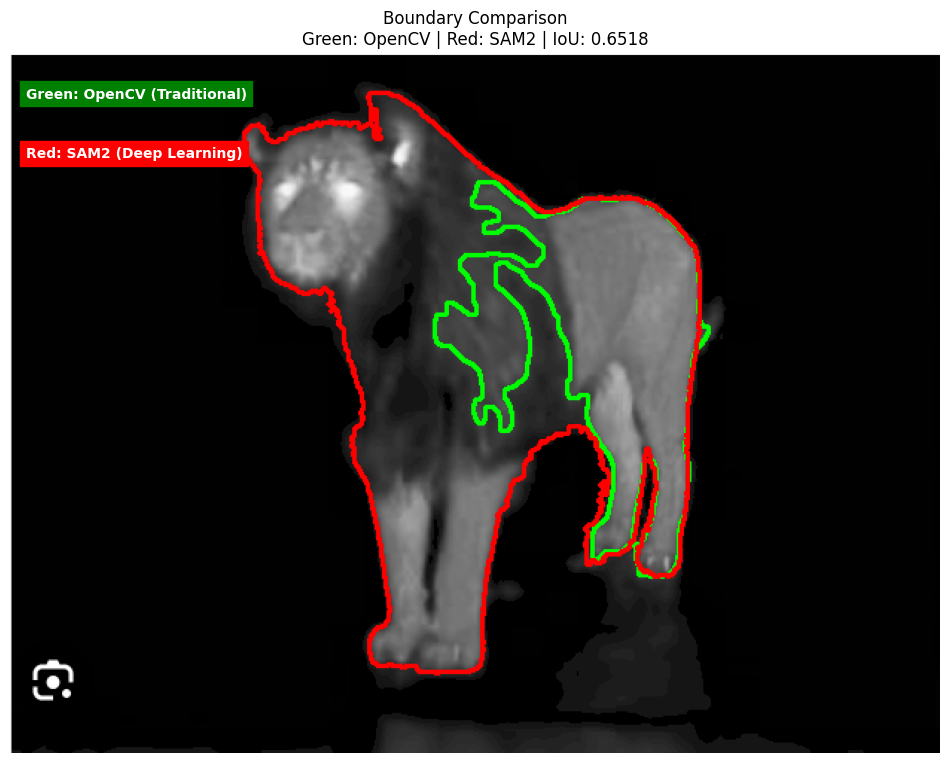

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare a base image in color to draw boundaries on
# Using the original thermal image as the background
comparison_canvas = cv2.cvtColor(original_gray, cv2.COLOR_GRAY2BGR)

# 2. Extract and Draw OpenCV Boundary (Green)
# Find contours from the OpenCV binary mask
contours_cv, _ = cv2.findContours(opencv_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours_cv:
    largest_cv = max(contours_cv, key=cv2.contourArea)
    cv2.drawContours(comparison_canvas, [largest_cv], -1, (0, 255, 0), 2) # Green for OpenCV

# 3. Extract and Draw SAM2 Boundary (Red)
# Find contours from the SAM2 binary mask
# Ensure sam_mask is converted to uint8 if it isn't already
sam_mask_uint8 = (sam_mask > 0).astype(np.uint8)
contours_sam, _ = cv2.findContours(sam_mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours_sam:
    largest_sam = max(contours_sam, key=cv2.contourArea)
    cv2.drawContours(comparison_canvas, [largest_sam], -1, (0, 0, 255), 2) # Red for SAM2

# 4. Final Display with Legend
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(comparison_canvas, cv2.COLOR_BGR2RGB))
plt.title(f"Boundary Comparison\nGreen: OpenCV | Red: SAM2 | IoU: {iou_score:.4f}")
plt.axis('off')

# Add a simple text legend on the image if needed
plt.text(10, 30, "Green: OpenCV (Traditional)", color='white', backgroundcolor='green', weight='bold')
plt.text(10, 70, "Red: SAM2 (Deep Learning)", color='white', backgroundcolor='red', weight='bold')

plt.savefig('exact_boundary_comparison.png')
plt.show()